# HuggingFace PatchTST test

1. Pendulum prediction test (transfer learning)

2. Pendulum representation learning test: encoder-decoder separation (transfer learning)

3. Train simple PatchTST ??


In [118]:
# Standard librairy
import os
from pathlib import Path
from tqdm import tqdm

# Librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# ML librairies
import torch
import torch.nn as nn

In [119]:
from transformers import (
    PatchTSTConfig,
    PatchTSTForPrediction
)

In [120]:
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

In [121]:
from transformers import set_seed

set_seed(2023)

In [122]:
# Load model directly

model_name = "namctin/patchtst_etth1_forecast"
token = os.getenv('HUGGING_FACE_HUB_TOKEN')


patch_tst = PatchTSTForPrediction.from_pretrained(model_name, use_auth_token=token)
print(patch_tst)
print("----------------")
print(patch_tst.model.encoder)
print("----------------")
print(patch_tst.head)

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

### Test the different parts (input and output shapes)

#### PatchTST total 

In [123]:
print(patch_tst)

PatchTSTForPrediction(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128, eps

In [124]:
configuration = patch_tst.config
print(configuration)

PatchTSTConfig {
  "_attn_implementation_autoset": true,
  "activation_function": "gelu",
  "architectures": [
    "PatchTSTForPrediction"
  ],
  "attention_dropout": 0.0,
  "bias": true,
  "channel_attention": false,
  "channel_consistent_masking": false,
  "context_length": 512,
  "d_model": 128,
  "distribution_output": "student_t",
  "do_mask_input": null,
  "dropout": 0.2,
  "ff_dropout": 0.0,
  "ffn_dim": 512,
  "head_dropout": 0.2,
  "init_std": 0.02,
  "loss": "mse",
  "mask_input": null,
  "mask_type": "random",
  "mask_value": 0,
  "model_type": "patchtst",
  "norm_eps": 1e-05,
  "norm_type": "batchnorm",
  "num_attention_heads": 16,
  "num_forecast_mask_patches": [
    2
  ],
  "num_hidden_layers": 3,
  "num_input_channels": 7,
  "num_parallel_samples": 100,
  "num_targets": 1,
  "output_range": null,
  "patch_length": 12,
  "patch_stride": 12,
  "path_dropout": 0.0,
  "pooling_type": null,
  "positional_dropout": 0.0,
  "positional_encoding_type": "sincos",
  "pre_norm": tr

In [125]:
x = torch.randn(32, 512, 7)     # (batch_size, seq_len, feature_dim)
print("Input shape:", x.shape)
y = patch_tst(x)

print(y)
print(y.keys())
print("Loc shape:", y["loc"].shape)                                      # (batch_size, 1, feature_dim)
print("Scale shape:", y["scale"].shape)                                  # (batch_size, 1, feature_dim)
print("Prediction output shape:", y["prediction_outputs"].shape)         # (batch_size, pred_len, feature_dim)

Input shape: torch.Size([32, 512, 7])
PatchTSTForPredictionOutput(loss=None, prediction_outputs=tensor([[[ 8.8112e-02,  1.7028e-01,  3.6903e-01,  ...,  7.0812e-02,
           1.7413e-01,  2.9766e-01],
         [ 8.6662e-02,  1.9881e-01,  3.8791e-01,  ...,  1.1349e-01,
           1.4575e-01,  2.9962e-01],
         [ 6.9755e-02,  2.1825e-01,  3.5104e-01,  ...,  1.5535e-01,
           8.8342e-02,  2.8630e-01],
         ...,
         [ 3.4225e-02,  1.0364e-01,  4.6721e-03,  ..., -6.8436e-02,
           7.2459e-02,  1.1766e-01],
         [ 5.4895e-02,  8.3268e-02,  1.1626e-01,  ..., -3.1151e-02,
           1.1622e-01,  1.5621e-01],
         [ 3.0978e-02,  5.2004e-02,  2.3360e-01,  ..., -2.0433e-02,
           1.1170e-01,  1.4780e-01]],

        [[ 3.1012e-02,  4.8573e-01,  2.5063e-01,  ...,  1.5257e-01,
           2.2662e-01, -4.2260e-01],
         [ 8.7236e-02,  4.8412e-01,  2.7962e-01,  ...,  5.9964e-02,
           2.2064e-01, -4.1747e-01],
         [ 1.2523e-01,  4.3521e-01,  2.8834e-01,

#### Model

In [126]:
model = patch_tst.model
print(model)

PatchTSTModel(
  (scaler): PatchTSTScaler(
    (scaler): PatchTSTStdScaler()
  )
  (patchifier): PatchTSTPatchify()
  (masking): Identity()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=128, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-2): 3 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): PatchTSTBatchNorm(
          (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (

In [127]:
if hasattr(model, 'config'):
    if model.config == configuration:
        print("Config is the same as the patchtst config")
    else:
        print("Config is different from the patchtst config")
        print("Model config:", model.config)
else:
    print("No config attribute for model")


Config is the same as the patchtst config


In [128]:
x = torch.randn(32, 512, 7)  # (batch_size, seq_len, feature_dim)
print(x.shape)
y = model(x)

print(y)
print(y.keys())
print(y["loc"].shape)               # (batch_size, 1, feature_dim)
print(y["scale"].shape)             # (batch_size, 1, feature_dim)
print(y["patch_input"].shape)       # (batch_size, feature_dim, n_patches, patch_len)
print(y["last_hidden_state"].shape) # (batch_size, feature_dim, n_patches, d_model)

torch.Size([32, 512, 7])
PatchTSTModelOutput(last_hidden_state=tensor([[[[ 1.1530e-01,  3.8802e-02, -5.7090e-01,  ...,  3.4679e-01,
            2.9975e-01,  2.9606e-01],
          [ 1.7347e-01,  4.6780e-01, -4.3653e-01,  ...,  2.4095e-01,
            2.3122e-01,  3.3059e-01],
          [ 3.4398e-01, -2.4829e-01, -2.1687e-01,  ...,  4.1609e-01,
            2.0628e-01,  1.7155e-01],
          ...,
          [-1.1571e-01,  4.2251e-01, -2.5873e-01,  ...,  1.8190e-01,
           -8.6008e-02,  9.3466e-02],
          [ 1.1427e-02, -3.0515e-01, -1.9051e-01,  ...,  1.1153e-01,
            1.3485e-01,  2.4354e-01],
          [ 1.5352e-01, -8.4608e-01, -9.8022e-01,  ...,  2.3162e-01,
            2.8967e-02,  3.4100e-01]],

         [[-2.1811e-01,  8.4555e-01, -4.9562e-01,  ...,  1.2342e-01,
           -8.0912e-02, -9.9286e-02],
          [-1.0289e-01,  1.3632e+00, -6.9327e-01,  ...,  2.6556e-01,
           -1.7301e-01,  2.6455e-01],
          [-7.7201e-02,  4.2372e-01, -6.7731e-02,  ..., -4.4374e

#### Scaler

In [129]:
scaler = patch_tst.model.scaler
print(scaler)

PatchTSTScaler(
  (scaler): PatchTSTStdScaler()
)


In [130]:
if hasattr(scaler, 'config'):
    if scaler.config == configuration:
        print("Config is the same as the patchtst config")
    else:
        print("Config is different from the patchtst config")
        print("scaler config:", scaler.config)
else:
    print("No config attribute for scaler")

No config attribute for scaler


In [131]:
print(help(scaler))

Help on PatchTSTScaler in module transformers.models.patchtst.modeling_patchtst object:

class PatchTSTScaler(torch.nn.modules.module.Module)
 |  PatchTSTScaler(config: transformers.models.patchtst.configuration_patchtst.PatchTSTConfig)
 |  
 |  Method resolution order:
 |      PatchTSTScaler
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, config: transformers.models.patchtst.configuration_patchtst.PatchTSTConfig)
 |      Initialize internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self, data: torch.Tensor, observed_indicator: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
 |      Parameters:
 |          data (`torch.Tensor` of shape `(batch_size, sequence_length, num_input_channels)`):
 |              Input for scaler calculation
 |          observed_indicator (`torch.BoolTensor` of shape `(batch_size, sequence_length, num_input_channels)`):
 |              Calculat

In [132]:
x = torch.randn(32, 512, 7)  # (batch_size, seq_len, feature_dim)
observed_indicator = torch.ones_like(x)
print(x.shape)
y = scaler(x, observed_indicator)


print(y)
print(y[0].shape)               # (batch_size, seq_len, feature_dim)
print(y[1].shape)               # (batch_size, 1, feature_dim)
print(y[2].shape)               # (batch_size, 1, feature_dim)

torch.Size([32, 512, 7])
(tensor([[[ 0.3972,  0.2267,  1.1127,  ..., -0.3972, -1.8628, -0.4584],
         [ 1.4118, -0.2611,  0.7645,  ..., -0.2996, -0.0775, -0.9644],
         [-0.7245, -0.1894,  0.6083,  ..., -0.0585,  0.0872, -1.4757],
         ...,
         [-0.0803,  0.3079,  0.3420,  ...,  0.4334, -0.3565, -0.6520],
         [-1.0479,  0.1220, -1.2501,  ...,  0.5923,  0.6201,  1.8374],
         [-0.6825,  2.2455, -0.2523,  ...,  1.1343,  0.3267,  0.2213]],

        [[ 0.5742,  0.5077, -0.7264,  ..., -0.4919,  2.5178,  1.8407],
         [ 0.8922, -0.0727, -0.5757,  ...,  1.5378,  0.7419, -0.7947],
         [-0.2786, -0.6793, -1.6733,  ...,  0.7933,  0.1786, -1.1213],
         ...,
         [-3.8304, -0.5799,  1.2930,  ...,  0.3280,  0.3620,  1.1060],
         [ 0.0528, -0.8538, -0.4834,  ..., -0.1926, -0.4699, -0.7764],
         [-0.1945, -0.0110, -1.1665,  ..., -0.5518, -0.1372, -1.1199]],

        [[ 0.6212, -1.2352, -0.0760,  ...,  0.3068, -1.5586,  1.2645],
         [-0.0947, 

#### Patchifier

In [133]:
patchifier = patch_tst.model.patchifier
print(patchifier)

PatchTSTPatchify()


In [134]:
if hasattr(patchifier, 'config'):
    if patchifier.config == configuration:
        print("Config is the same as the patchtst config")
    else:
        print("Config is different from the patchtst config")
        print("patchifier config:", patchifier.config)
else:
    print("No config attribute for patchifier")

No config attribute for patchifier


In [135]:
# print(help(patchifier))

In [136]:
x = torch.randn(32, 512, 7)  # (batch_size, seq_len, feature_dim)
print(x.shape)
y = patchifier(x)

print(y)
print(y.shape)

torch.Size([32, 512, 7])
tensor([[[[ 2.6716e+00, -1.2197e-01,  5.1084e-01,  ...,  6.0517e-01,
           -5.6489e-01,  2.5530e-01],
          [ 1.1997e-01,  1.1466e-01,  2.4277e-01,  ...,  7.8695e-01,
            3.6354e-02,  4.6507e-01],
          [ 9.8573e-01,  1.3754e-01, -4.4183e-02,  ..., -9.5744e-02,
            2.8034e+00,  1.0092e+00],
          ...,
          [ 3.0133e-01,  2.0709e+00, -1.4508e-02,  ..., -5.4333e-01,
            6.0142e-02, -2.0382e-01],
          [ 5.8343e-01, -1.6002e+00, -8.7410e-01,  ...,  2.6471e-01,
            3.1500e-01, -1.6383e+00],
          [ 2.2934e+00,  8.4243e-01, -2.5930e-02,  ..., -1.6417e+00,
            1.3874e+00, -4.1150e-01]],

         [[-4.9003e-01, -4.9462e-01,  1.4232e+00,  ...,  3.5034e-01,
           -7.0691e-01,  1.0614e+00],
          [-6.1696e-01, -7.4324e-01, -9.9000e-01,  ..., -3.8949e-01,
            1.9900e+00,  6.3477e-01],
          [-1.9229e+00,  2.4430e+00,  9.9762e-01,  ..., -3.8964e-02,
            1.2430e+00,  4.5243e-

#### Masking

In [137]:
masking = patch_tst.model.masking
print(masking)

Identity()


In [138]:
if hasattr(masking, 'config'):
    if masking.config == configuration:
        print("Config is the same as the patchtst config")
    else:
        print("Config is different from the patchtst config")
        print("masking config:", masking.config)
else:
    print("No config attribute for masking")

No config attribute for masking


In [139]:
# print(help(masking))

In [140]:
x = torch.ones(32, 512, 12)  # (batch_size, seq_len, feature_dim)
print(x.shape)
y = masking(x)

print(y)
print(y.shape)
assert (x.numpy() == y.numpy()).all()

torch.Size([32, 512, 12])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1

#### Encoder

In [141]:
encoder = patch_tst.model.encoder
print(encoder)


PatchTSTEncoder(
  (embedder): PatchTSTEmbedding(
    (input_embedding): Linear(in_features=12, out_features=128, bias=True)
  )
  (positional_encoder): PatchTSTPositionalEncoding(
    (positional_dropout): Identity()
  )
  (layers): ModuleList(
    (0-2): 3 x PatchTSTEncoderLayer(
      (self_attn): PatchTSTAttention(
        (k_proj): Linear(in_features=128, out_features=128, bias=True)
        (v_proj): Linear(in_features=128, out_features=128, bias=True)
        (q_proj): Linear(in_features=128, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (dropout_path1): Identity()
      (norm_sublayer1): PatchTSTBatchNorm(
        (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): GELUActivation()
        (2): Identity()
        (3): Linear(in_features=512, out_features=128,

In [142]:
if hasattr(encoder, 'config'):
    if encoder.config == configuration:
        print("Config is the same as the patchtst config")
    else:
        print("Config is different from the patchtst config")
        print("encoder config:", encoder.config)
else:
    print("No config attribute for encoder")

Config is the same as the patchtst config


In [143]:
# print(help(encoder))

In [144]:
x = torch.randn(32, 7, 42, 12)  # (batch_size, seq_len, feature_dim)
print(x.shape)
y = encoder(x)

print(y)
print(y.keys())
print(y["last_hidden_state"].shape) # (batch_size, feature_dim, n_patches, d_model)

torch.Size([32, 7, 42, 12])
BaseModelOutput(last_hidden_state=tensor([[[[-1.7059e-01,  3.5728e-02,  1.3017e-01,  ..., -6.3459e-01,
           -1.4387e-01, -5.5916e-01],
          [-1.7156e-02, -1.5409e-01,  6.1539e-01,  ..., -5.6577e-01,
            2.8412e-02, -5.2964e-01],
          [ 1.3428e-01, -2.2634e-01, -1.5831e-01,  ..., -3.1195e-01,
           -1.8213e-01, -2.2653e-01],
          ...,
          [-1.0776e-01, -2.2477e-02, -4.2349e-01,  ..., -3.8298e-01,
           -5.5220e-01, -4.8367e-01],
          [-4.5110e-02, -9.1619e-03, -1.2861e-01,  ..., -4.7202e-01,
           -1.6093e-01, -3.8218e-01],
          [-1.8988e-01,  4.5202e-01,  1.0803e-01,  ..., -4.7452e-01,
            6.1693e-02,  1.7700e-01]],

         [[-4.5324e-01,  7.9789e-01, -8.6619e-01,  ...,  1.2203e-02,
           -1.5963e-01, -3.3243e-01],
          [-3.6295e-01,  9.5589e-01, -6.2298e-01,  ...,  2.4897e-01,
           -1.8741e-01, -5.3131e-02],
          [-1.2978e-01,  3.6470e-02, -7.4439e-01,  ...,  1.8562e-

#### Encoder components

In [145]:
x0 = torch.randn(32, 7, 42, 12)  # (batch_size, features_dim, n_patches, len_patch)
x1 = encoder.embedder(x0)
x2 = encoder.positional_encoder(x1)
x3 = torch.randn(11, 22, 33, 128)
x3 = encoder.layers[0](x3)
x3 = x3[0]
x3 = encoder.layers[1](x3)
# print(x1)
# print(x2)
print(len(x3))
print(x1.shape)  # (batch_size, features_dim, n_patches, d_model)
print(x2.shape)  # (batch_size, features_dim, n_patches, d_model)
print(x3[0].shape)  # (batch_size, features_dim, n_patches, d_model)

1
torch.Size([32, 7, 42, 128])
torch.Size([32, 7, 43, 128])
torch.Size([11, 22, 33, 128])


#### Head

In [146]:
head = patch_tst.head
print(head)

PatchTSTPredictionHead(
  (flatten): Flatten(start_dim=2, end_dim=-1)
  (projection): Linear(in_features=128, out_features=96, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [147]:
if hasattr(head, 'config'):
    if head.config == configuration:
        print("Config is the same as the patchtst config")
    else:
        print("Config is different from the patchtst config")
        print("head config:", head.config)
else:
    print("No config attribute for head")

No config attribute for head


In [148]:
# print(help(head))

In [149]:
x = torch.randn(32, 7, 42, 128)  # (batch_size, feature_dim, n_patches, d_model)
print(x.shape)
y = head(x)

print(y)
print(y.shape)

torch.Size([32, 7, 42, 128])
tensor([[[-0.1354,  0.4033, -0.0155,  ..., -0.1611,  0.0125,  0.0577],
         [-0.3234,  0.3424, -0.2550,  ..., -0.1485, -0.4947,  0.1702],
         [ 0.0599,  0.2622, -0.1050,  ..., -0.3702, -0.0433, -0.4791],
         ...,
         [-0.1392,  0.2729, -0.0319,  ..., -0.2653, -0.3301,  0.2183],
         [-0.4272,  0.4116, -0.2587,  ..., -0.4063, -0.2970,  0.1108],
         [ 0.0620,  0.2191, -0.1331,  ..., -0.1038, -0.1996,  0.2124]],

        [[ 0.3768,  0.1791, -0.2440,  ..., -0.0517,  0.1739, -0.0062],
         [ 0.5042,  0.0958,  0.0570,  ..., -0.2111,  0.1739, -0.4097],
         [ 0.7940,  0.0791,  0.3117,  ...,  0.1187,  0.1764, -0.5925],
         ...,
         [-0.2983, -0.2720,  0.0367,  ..., -0.1240,  0.4437, -0.1258],
         [ 0.3337, -0.2774, -0.4875,  ..., -0.0276,  0.3326,  0.0426],
         [-0.0398,  0.1002, -0.0268,  ...,  0.1891,  0.2481,  0.0864]],

        [[ 0.0373,  0.0627, -0.1637,  ...,  0.0972, -0.2946,  0.3979],
         [-0.012

### Test on synthetic data: pendulum

In [150]:
model_name = "namctin/patchtst_etth1_forecast"
token = os.getenv('HUGGING_FACE_HUB_TOKEN')
patch_tst = PatchTSTForPrediction.from_pretrained(model_name, use_auth_token=token)

In [151]:
# Timeserie d'un pendule amorti
def create_wave(kapa, beta, t, A=1, m=1):
    #return A * np.exp(-beta * t / (2 * m)) * np.cos(np.sqrt(kapa - (beta / (2 * m))**2) * t)
    return A * np.cos(kapa * t)
Create_wave = np.vectorize(create_wave)

kapa = np.linspace(1.0, 10.0, 7)[np.newaxis, :]
beta = np.linspace(0.05, 0.5, 7)[np.newaxis, :]

time_past = np.linspace(0, 10, 512)[:, np.newaxis]
wave_past = Create_wave(kapa, beta, time_past)
wave_past = torch.tensor(wave_past, dtype=torch.float32).unsqueeze(0)

time_future = np.linspace(10, 12, 96)[:, np.newaxis]
wave_future = Create_wave(kapa, beta, time_future)
wave_future = torch.tensor(wave_future, dtype=torch.float32).unsqueeze(0)

print(wave_past.shape)
print(wave_future.shape)

batch = {
    "past_values": wave_past,
    "future_values": wave_future
}
batch

torch.Size([1, 512, 7])
torch.Size([1, 96, 7])


{'past_values': tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9998,  0.9988,  0.9969,  ...,  0.9906,  0.9862,  0.9809],
          [ 0.9992,  0.9952,  0.9878,  ...,  0.9627,  0.9452,  0.9244],
          ...,
          [-0.8597,  0.9735, -0.5426,  ...,  0.8191, -0.9879,  0.6039],
          [-0.8496,  0.9835, -0.6066,  ...,  0.7331, -0.9999,  0.7474],
          [-0.8391,  0.9912, -0.6669,  ...,  0.6333, -0.9844,  0.8623]]]),
 'future_values': tensor([[[-0.8391,  0.9912, -0.6669,  0.0221,  0.6333, -0.9844,  0.8623],
          [-0.8274,  0.9968, -0.7272,  0.1375,  0.5128, -0.9373,  0.9491],
          [-0.8154,  0.9996, -0.7824,  0.2510,  0.3812, -0.8603,  0.9940],
          [-0.8031,  0.9997, -0.8320,  0.3611,  0.2413, -0.7559,  0.9949],
          [-0.7903,  0.9970, -0.8757,  0.4665,  0.0962, -0.6272,  0.9520],
          [-0.7773,  0.9915, -0.9132,  0.5655, -0.0510, -0.4786,  0.8670],
          [-0.7639,  0.9833, -0.9443,  0.6570, -0.1971, -0.3147,  0.

In [ ]:
patch_tst.eval()
with torch.no_grad():
    outputs_inference = patch_tst(past_values=batch["past_values"])
    predictions = outputs_inference.prediction_outputs * batch["past_values"].std(dim=1, keepdim=True) + batch["past_values"].mean(dim=1, keepdim=True)
    
    past_values_np = batch["past_values"].numpy()
    predictions_np = predictions.numpy()
    
    if "future_values" in batch:
        future_values_np = batch["future_values"].numpy()

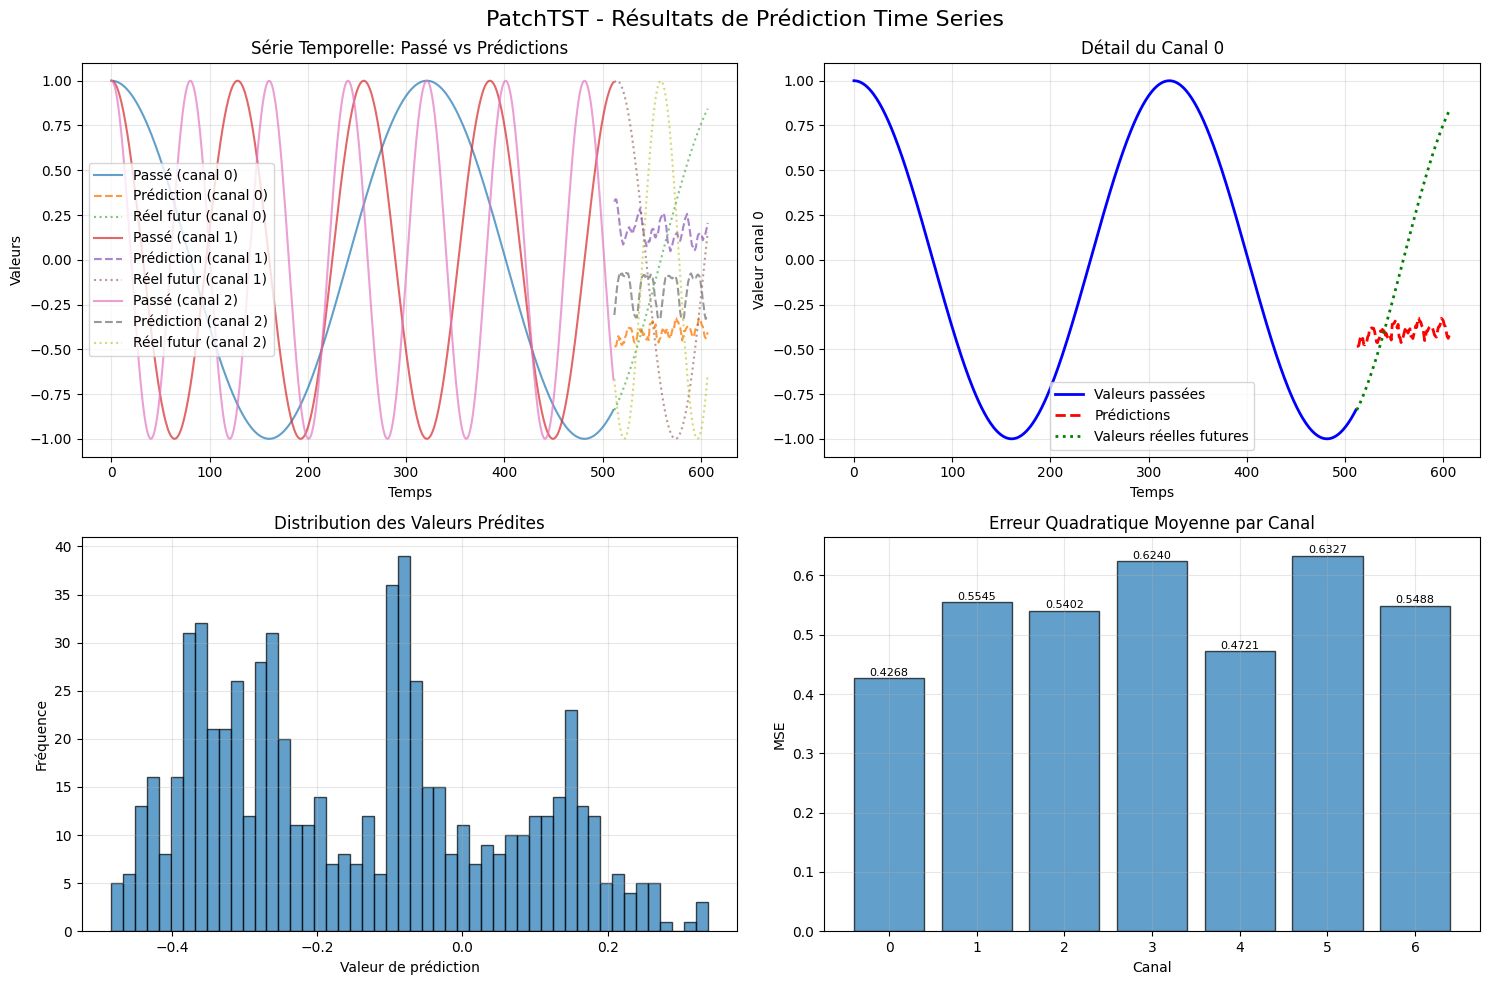

In [153]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PatchTST - Résultats de Prédiction Time Series', fontsize=16)

# Graphique 1: Série temporelle complète avec prédictions
ax1 = axes[0, 0]
time_axis_past = np.arange(past_values_np.shape[1])
time_axis_future = np.arange(past_values_np.shape[1], 
                            past_values_np.shape[1] + predictions_np.shape[1])

# Affichage de quelques canaux sélectionnés
channels_to_plot = min(3, past_values_np.shape[2])  # Maximum 3 canaux

for i in range(channels_to_plot):
    ax1.plot(time_axis_past, past_values_np[0, :, i], 
             label=f'Passé (canal {i})', alpha=0.7)
    ax1.plot(time_axis_future, predictions_np[0, :, i], 
             '--', label=f'Prédiction (canal {i})', alpha=0.8)
    
    if "future_values" in batch:
        ax1.plot(time_axis_future, future_values_np[0, :, i], 
                 ':', label=f'Réel futur (canal {i})', alpha=0.6)

ax1.set_xlabel('Temps')
ax1.set_ylabel('Valeurs')
ax1.set_title('Série Temporelle: Passé vs Prédictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Détail d'un canal spécifique
ax2 = axes[0, 1]
channel_to_detail = 0  # Premier canal

ax2.plot(time_axis_past, past_values_np[0, :, channel_to_detail], 
         'b-', label='Valeurs passées', linewidth=2)
ax2.plot(time_axis_future, predictions_np[0, :, channel_to_detail], 
         'r--', label='Prédictions', linewidth=2)

if "future_values" in batch:
    ax2.plot(time_axis_future, future_values_np[0, :, channel_to_detail], 
             'g:', label='Valeurs réelles futures', linewidth=2)

ax2.set_xlabel('Temps')
ax2.set_ylabel(f'Valeur canal {channel_to_detail}')
ax2.set_title(f'Détail du Canal {channel_to_detail}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graphique 3: Distribution des prédictions
ax3 = axes[1, 0]
all_predictions = predictions_np.flatten()
ax3.hist(all_predictions, bins=50, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Valeur de prédiction')
ax3.set_ylabel('Fréquence')
ax3.set_title('Distribution des Valeurs Prédites')
ax3.grid(True, alpha=0.3)

# Graphique 4: Métriques par canal (si valeurs futures disponibles)
ax4 = axes[1, 1]
if "future_values" in batch:
    mse_by_channel = np.mean((predictions_np - future_values_np) ** 2, axis=1)[0]
    channels = range(len(mse_by_channel))
    
    bars = ax4.bar(channels, mse_by_channel, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('MSE')
    ax4.set_title('Erreur Quadratique Moyenne par Canal')
    ax4.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, mse_by_channel):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontsize=8)
else:
    # Graphique alternatif: amplitudes par canal
    amplitudes = np.ptp(predictions_np, axis=1)[0]  # Peak-to-peak
    channels = range(len(amplitudes))
    
    bars = ax4.bar(channels, amplitudes, alpha=0.7, edgecolor='black', color='orange')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('Amplitude (max-min)')
    ax4.set_title('Amplitude des Prédictions par Canal')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [154]:
print(f"Forme des données passées: {batch['past_values'].shape}")
print(f"Forme des prédictions: {predictions.shape}")
print(f"Longueur de prédiction: {predictions.shape[1]} pas de temps")
print(f"Nombre de canaux: {predictions.shape[2]}")

if "future_values" in batch:
    print(f"Forme des valeurs futures réelles: {batch['future_values'].shape}")
    
    # Calcul des métriques globales
    mse_total = np.mean((predictions_np - future_values_np) ** 2)
    print(f"MSE total: {mse_total:.6f}")

Forme des données passées: torch.Size([1, 512, 7])
Forme des prédictions: torch.Size([1, 96, 7])
Longueur de prédiction: 96 pas de temps
Nombre de canaux: 7
Forme des valeurs futures réelles: torch.Size([1, 96, 7])
MSE total: 0.542720


### Test with fine tuning of the head only

In [254]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [289]:
class CustomDecoder(nn.Module):
    def __init__(self, encoder_dim, prediction_length, num_features, hidden_dim=256, num_layers=2):
        super().__init__()
        
        self.prediction_length = prediction_length
        self.num_features = num_features
        
        self.layers = nn.ModuleList()
        # First layer
        self.layers.append(nn.Linear(encoder_dim, hidden_dim))
        self.layers.append(nn.GELU())
        self.layers.append(nn.Dropout(0.2))
        # Other layers
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.GELU())
            self.layers.append(nn.Dropout(0.2))
        # Output layer
        self.output_layer = nn.Linear(hidden_dim, prediction_length)
        
    def forward(self, x):
        # x shape: (batch_size, num_features, num_patches, encoder_dim)
        # Aggregation of all patches
        # x = x.mean(dim=2)           # (batch_size, num_features, encoder_dim)
        # Gather and flatten the num_patches and encoder dimension
        x = x.view(x.size(0), x.size(1), -1)  # (batch_size, num_features, num_patches * encoder_dim)
        for layer in self.layers:
            x = layer(x)
        output = self.output_layer(x)  # (batch_size, prediction_length * num_features)
        output = output.view(-1, self.prediction_length, self.num_features) # (batch_size, prediction_length, num_features)
        return output

In [305]:
class NewModelWithCustomDecoder(nn.Module):
    def __init__(self, patchtst_model, prediction_length, num_features, decoder_hidden_dim=256, num_layers=2):
        super().__init__()
        self.patchifier = patchtst_model.model.patchifier
        self.encoder = patchtst_model.model.encoder
        for param in self.patchifier.parameters():
            param.requires_grad = False
        for param in self.encoder.parameters():
            param.requires_grad = False
        
        self.decoder = CustomDecoder(
            encoder_dim=128*43,  # d_model of encoder
            prediction_length=prediction_length,
            num_features=num_features,
            hidden_dim=decoder_hidden_dim,
            num_layers=num_layers
        )
        
    def forward(self, x):#, observed_indicator=None):
        # if observed_indicator is None:
        #     observed_indicator = torch.ones_like(x[..., :1])
        with torch.no_grad():
            x = self.patchifier(x)
            encoded = self.encoder(x)["last_hidden_state"]
        output = self.decoder(encoded)
        return output

In [316]:
# New model with custom decoder
patchtst_model = PatchTSTForPrediction.from_pretrained(
    "namctin/patchtst_etth1_forecast", 
    use_auth_token=os.getenv('HUGGING_FACE_HUB_TOKEN')
    )
new_model = NewModelWithCustomDecoder(
    patchtst_model=patchtst_model,
    prediction_length=96,
    num_features=7,
    decoder_hidden_dim=256,
    num_layers=3
)
new_model

NewModelWithCustomDecoder(
  (patchifier): PatchTSTPatchify()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=128, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-2): 3 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): PatchTSTBatchNorm(
          (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias

In [307]:
optimizer = torch.optim.Adam(new_model.decoder.parameters(), lr=5e-3)
criterion = nn.MSELoss()

In [294]:
def create_wave(kapa, beta, t, A=1, m=1):
    #return A * np.exp(-beta * t / (2 * m)) * np.cos(np.sqrt(kapa - (beta / (2 * m))**2) * t)
    return A * np.cos(kapa * t)
Create_wave = np.vectorize(create_wave)
kapa = np.linspace(2.0, 8.0, 7)[np.newaxis, :]
beta = np.linspace(0.05, 0.5, 7)[np.newaxis, :]

time_past = np.linspace(0, 50000, 5120096)[:, np.newaxis]
wave_past = Create_wave(kapa, beta, time_past)

print(wave_past.shape)

(5120096, 7)


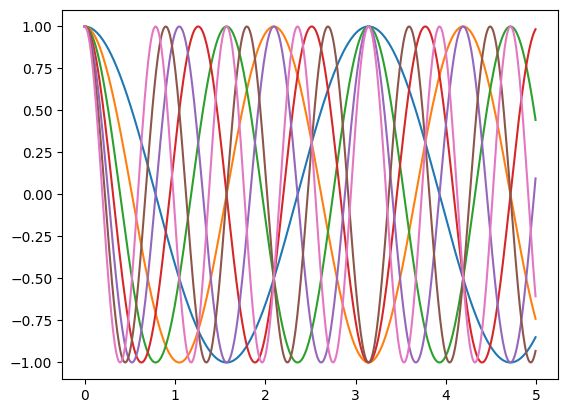

In [295]:
plt.plot(time_past[:512], wave_past[:512])
plt.show()

In [308]:
# Creation of dataset and dataloader

class WaveDataset(torch.utils.data.Dataset):
    def __init__(self, wave_data, past_length=512, future_length=96, stride=512):
        self.wave_data = wave_data
        self.past_length = past_length
        self.future_length = future_length
        self.stride = stride
    
        self.num_samples = (len(wave_data) - past_length - future_length) // stride

    def __len__(self):
        return (len(self.wave_data) - self.past_length - self.future_length) // self.stride

    def __getitem__(self, idx):
        start_idx = idx * self.stride
        past = self.wave_data[start_idx:start_idx + self.past_length, :]

        future_start = start_idx + self.past_length
        future = self.wave_data[future_start:future_start + self.future_length, :]
        
        return {"past_values": past, "future_values": future}

dataset = WaveDataset(wave_past, past_length=512, future_length=96, stride=512)

print(f"Longueur du dataset: {len(dataset)}")
print(f"Taille des données d'entrée: {len(wave_past)}")
print(f"Nombre d'échantillons valides: {len(dataset)}")

if len(dataset) > 0:
    sample = dataset[0]
    print(f"Exemple d'élément du dataset: {sample['past_values'].shape}, {sample['future_values'].shape}")
else:
    print("Le dataset est vide - vérifiez la longueur de vos données")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, drop_last=True)

for batch in dataloader:
    print(f"\nBatch past values shape: {batch['past_values'].shape}")
    print(f"Batch future values shape: {batch['future_values'].shape}")
    print(batch.keys())
    break

Longueur du dataset: 9999
Taille des données d'entrée: 5120096
Nombre d'échantillons valides: 9999
Exemple d'élément du dataset: (512, 7), (96, 7)

Batch past values shape: torch.Size([512, 512, 7])
Batch future values shape: torch.Size([512, 96, 7])
dict_keys(['past_values', 'future_values'])


In [309]:
# Print the parameters of the new model
new_model.to(device)
print(new_model)

# Print trainable parameters
trainable_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in new_model.parameters())
print(f"Trainable parameters: {trainable_params} / {total_params} ({100*trainable_params/total_params:.2f}%)")
print("Encoder parameter number: ", sum(p.numel() for p in new_model.encoder.parameters()))
print("Decoder parameter number: ", sum(p.numel() for p in new_model.decoder.parameters()))
print("Total parameter number: ", sum(p.numel() for p in new_model.parameters()))

NewModelWithCustomDecoder(
  (patchifier): PatchTSTPatchify()
  (encoder): PatchTSTEncoder(
    (embedder): PatchTSTEmbedding(
      (input_embedding): Linear(in_features=12, out_features=128, bias=True)
    )
    (positional_encoder): PatchTSTPositionalEncoding(
      (positional_dropout): Identity()
    )
    (layers): ModuleList(
      (0-2): 3 x PatchTSTEncoderLayer(
        (self_attn): PatchTSTAttention(
          (k_proj): Linear(in_features=128, out_features=128, bias=True)
          (v_proj): Linear(in_features=128, out_features=128, bias=True)
          (q_proj): Linear(in_features=128, out_features=128, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
        )
        (dropout_path1): Identity()
        (norm_sublayer1): PatchTSTBatchNorm(
          (batchnorm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=512, bias

In [310]:
history = {"train_loss_epoch": [], "train_loss_step": []}
N_epoch = 100

# patch_tst.to(device)
new_model.to(device)
for epoch in range(N_epoch):
    loss_total = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{N_epoch}", leave=False):
        past_values = batch['past_values'].float().to(device)
        future_values = batch['future_values'].float().to(device)

        optimizer.zero_grad()
        predictions = new_model(past_values) * past_values.std(dim=1, keepdim=True) + past_values.mean(dim=1, keepdim=True)

        loss = criterion(predictions, future_values)
        loss.backward()
        optimizer.step()
        history["train_loss_step"].append(loss.item())
        loss_total += loss.item()

    history["train_loss_epoch"].append(loss_total / len(dataloader))
    print(f"Epoch {epoch+1}/{N_epoch}, Loss: {loss_total / len(dataloader):.6f}")


Epoch 1/100, Loss: 0.500171


Epoch 2/100, Loss: 0.438242


Epoch 3/100, Loss: 0.429479


Epoch 4/100, Loss: 0.427006


Epoch 5/100, Loss: 0.425413


Epoch 6/100, Loss: 0.424336


Epoch 7/100, Loss: 0.423697


Epoch 8/100, Loss: 0.423407


Epoch 9/100, Loss: 0.423366


Epoch 10/100, Loss: 0.423351


Epoch 11/100, Loss: 0.423049


Epoch 12/100, Loss: 0.422921


Epoch 13/100, Loss: 0.423190


Epoch 14/100, Loss: 0.422504


Epoch 15/100, Loss: 0.422649


Epoch 16/100, Loss: 0.422126


Epoch 17/100, Loss: 0.422506


Epoch 18/100, Loss: 0.422175


Epoch 19/100, Loss: 0.422132


Epoch 20/100, Loss: 0.422167


Epoch 21/100, Loss: 0.421930


Epoch 22/100, Loss: 0.422014


KeyboardInterrupt: 

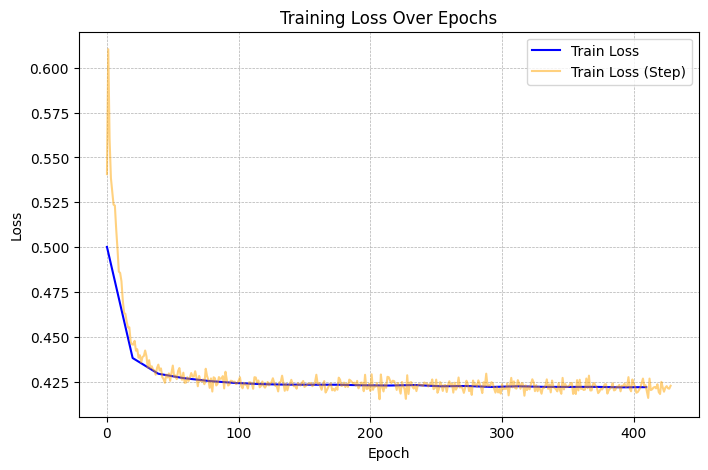

In [311]:
fig = plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(history["train_loss_epoch"]))*len(history["train_loss_step"])/len(history["train_loss_epoch"]), history["train_loss_epoch"], label='Train Loss', color='blue')
plt.plot(np.arange(len(history["train_loss_step"])), history["train_loss_step"], label='Train Loss (Step)', color='orange', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

In [312]:
# Timeserie d'un pendule amorti
def create_wave(kapa, beta, t, A=1, m=1):
    #return A * np.exp(-beta * t / (2 * m)) * np.cos(np.sqrt(kapa - (beta / (2 * m))**2) * t)
    return A * np.cos(kapa * t)
Create_wave = np.vectorize(create_wave)

kapa = np.linspace(1.0, 10.0, 7)[np.newaxis, :]
beta = np.linspace(0.05, 0.5, 7)[np.newaxis, :]

time_past = np.linspace(0, 10, 512)[:, np.newaxis]
wave_past = Create_wave(kapa, beta, time_past)
wave_past = torch.tensor(wave_past, dtype=torch.float32).unsqueeze(0)

time_future = np.linspace(10, 12, 96)[:, np.newaxis]
wave_future = Create_wave(kapa, beta, time_future)
wave_future = torch.tensor(wave_future, dtype=torch.float32).unsqueeze(0)

print(wave_past.shape)
print(wave_future.shape)

batch = {
    "past_values": wave_past,
    "future_values": wave_future
}
batch

torch.Size([1, 512, 7])
torch.Size([1, 96, 7])


{'past_values': tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 0.9998,  0.9988,  0.9969,  ...,  0.9906,  0.9862,  0.9809],
          [ 0.9992,  0.9952,  0.9878,  ...,  0.9627,  0.9452,  0.9244],
          ...,
          [-0.8597,  0.9735, -0.5426,  ...,  0.8191, -0.9879,  0.6039],
          [-0.8496,  0.9835, -0.6066,  ...,  0.7331, -0.9999,  0.7474],
          [-0.8391,  0.9912, -0.6669,  ...,  0.6333, -0.9844,  0.8623]]]),
 'future_values': tensor([[[-0.8391,  0.9912, -0.6669,  0.0221,  0.6333, -0.9844,  0.8623],
          [-0.8274,  0.9968, -0.7272,  0.1375,  0.5128, -0.9373,  0.9491],
          [-0.8154,  0.9996, -0.7824,  0.2510,  0.3812, -0.8603,  0.9940],
          [-0.8031,  0.9997, -0.8320,  0.3611,  0.2413, -0.7559,  0.9949],
          [-0.7903,  0.9970, -0.8757,  0.4665,  0.0962, -0.6272,  0.9520],
          [-0.7773,  0.9915, -0.9132,  0.5655, -0.0510, -0.4786,  0.8670],
          [-0.7639,  0.9833, -0.9443,  0.6570, -0.1971, -0.3147,  0.

In [313]:
new_model.eval()
with torch.no_grad():
    past_values, future_values = batch["past_values"].to(device).float(), batch["future_values"].to(device).float()

    outputs_inference = new_model(past_values)
    predictions = outputs_inference * past_values.std(dim=1, keepdim=True) + past_values.mean(dim=1, keepdim=True)

    past_values_np = past_values.cpu().numpy()
    predictions_np = predictions.cpu().numpy()
    
    if "future_values" in batch:
        future_values_np = future_values.cpu().numpy()

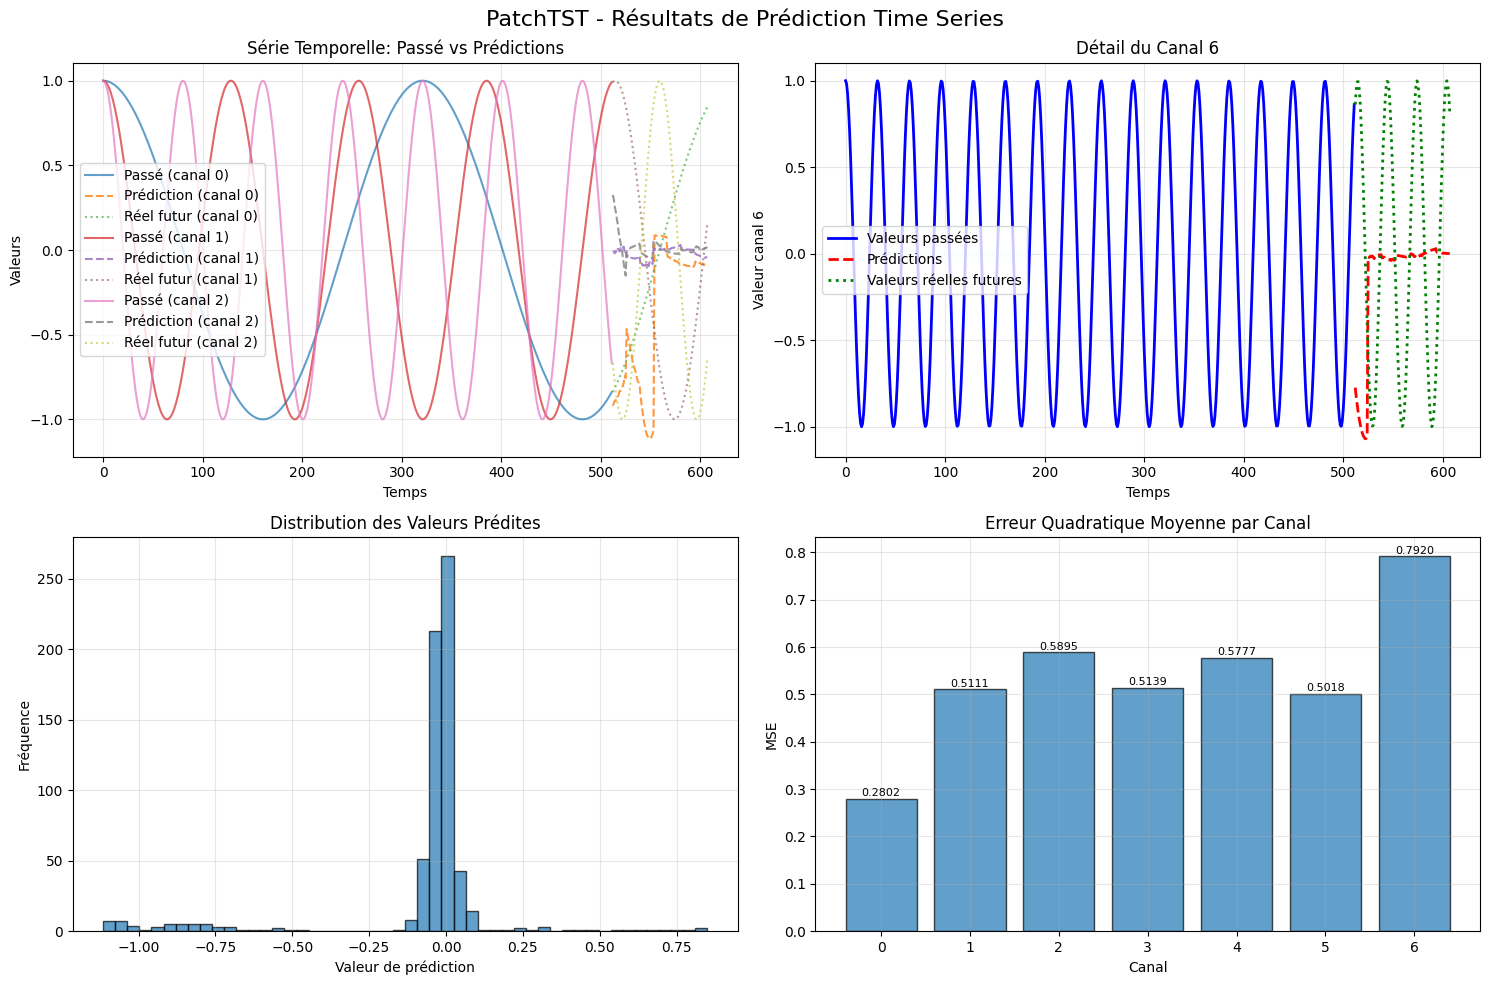

In [314]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('PatchTST - Résultats de Prédiction Time Series', fontsize=16)

# Graphique 1: Série temporelle complète avec prédictions
ax1 = axes[0, 0]
time_axis_past = np.arange(past_values_np.shape[1])
time_axis_future = np.arange(past_values_np.shape[1], 
                            past_values_np.shape[1] + predictions_np.shape[1])

# Affichage de quelques canaux sélectionnés
channels_to_plot = min(3, past_values_np.shape[2])  # Maximum 3 canaux

for i in range(channels_to_plot):
    ax1.plot(time_axis_past, past_values_np[0, :, i], 
             label=f'Passé (canal {i})', alpha=0.7)
    ax1.plot(time_axis_future, predictions_np[0, :, i], 
             '--', label=f'Prédiction (canal {i})', alpha=0.8)
    
    if "future_values" in batch:
        ax1.plot(time_axis_future, future_values_np[0, :, i], 
                 ':', label=f'Réel futur (canal {i})', alpha=0.6)

ax1.set_xlabel('Temps')
ax1.set_ylabel('Valeurs')
ax1.set_title('Série Temporelle: Passé vs Prédictions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Détail d'un canal spécifique
ax2 = axes[0, 1]
channel_to_detail = 6  # Premier canal

ax2.plot(time_axis_past, past_values_np[0, :, channel_to_detail], 
         'b-', label='Valeurs passées', linewidth=2)
ax2.plot(time_axis_future, predictions_np[0, :, channel_to_detail], 
         'r--', label='Prédictions', linewidth=2)

if "future_values" in batch:
    ax2.plot(time_axis_future, future_values_np[0, :, channel_to_detail], 
             'g:', label='Valeurs réelles futures', linewidth=2)

ax2.set_xlabel('Temps')
ax2.set_ylabel(f'Valeur canal {channel_to_detail}')
ax2.set_title(f'Détail du Canal {channel_to_detail}')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Graphique 3: Distribution des prédictions
ax3 = axes[1, 0]
all_predictions = predictions_np.flatten()
ax3.hist(all_predictions, bins=50, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Valeur de prédiction')
ax3.set_ylabel('Fréquence')
ax3.set_title('Distribution des Valeurs Prédites')
ax3.grid(True, alpha=0.3)

# Graphique 4: Métriques par canal (si valeurs futures disponibles)
ax4 = axes[1, 1]
if "future_values" in batch:
    mse_by_channel = np.mean((predictions_np - future_values_np) ** 2, axis=1)[0]
    channels = range(len(mse_by_channel))
    
    bars = ax4.bar(channels, mse_by_channel, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('MSE')
    ax4.set_title('Erreur Quadratique Moyenne par Canal')
    ax4.grid(True, alpha=0.3)
    
    # Ajout des valeurs sur les barres
    for bar, value in zip(bars, mse_by_channel):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontsize=8)
else:
    # Graphique alternatif: amplitudes par canal
    amplitudes = np.ptp(predictions_np, axis=1)[0]  # Peak-to-peak
    channels = range(len(amplitudes))
    
    bars = ax4.bar(channels, amplitudes, alpha=0.7, edgecolor='black', color='orange')
    ax4.set_xlabel('Canal')
    ax4.set_ylabel('Amplitude (max-min)')
    ax4.set_title('Amplitude des Prédictions par Canal')
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Test en ETTh1

We download ETT dataset (h1 version) on github at:

https://github.com/zhouhaoyi/ETDataset

In [ ]:
timestamp_column = "date"
id_columns = []
forecast_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL", "OT"]
train_start_index = None  # None indicates beginning of dataset
train_end_index = 12 * 30 * 24

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = 12 * 30 * 24 - context_length
valid_end_index = 12 * 30 * 24 + 4 * 30 * 24

test_start_index = 12 * 30 * 24 + 4 * 30 * 24 - context_length
test_end_index = 12 * 30 * 24 + 8 * 30 * 24

In [ ]:
data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_preprocessor = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    scaling=True,
)
time_series_preprocessor = time_series_preprocessor.train(train_data)


In [ ]:
train_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(train_data),
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(valid_data),
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_preprocessor.preprocess(test_data),
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    context_length=context_length,
    prediction_length=forecast_horizon,
)
